<a href="https://colab.research.google.com/github/park-gb/financial-news-sentiment-classifier/blob/main/Sentiment_Classifier_for_Kor_Financial_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info
Last Updated @2022-05-31

### 👨‍💻 Author Info
- Author: Gyeongbin Park(a.k.a., Tony Park)
- Blog: https://heytech.tistory.com/
- Github: https://github.com/park-gb
- Contact: dev.gbpark@gmail.com

### 📚 References
- PLM(KLUE/Bert-base): https://huggingface.co/klue/bert-base
- Dataset: https://github.com/ukairia777/finance_sentiment_corpus/blob/main/finance_data.csv

# 구글 드라이브 연동

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
cd /content/drive/MyDrive/Colab Notebooks/financial-news-sentiment-classifier

/content/drive/MyDrive/Colab Notebooks/financial-news-sentiment-classifier


In [42]:
!git init

Reinitialized existing Git repository in /content/drive/MyDrive/Colab Notebooks/financial-news-sentiment-classifier/.git/


In [43]:
!git remote -v

origin	https://github.com/park-gb/financial-news-sentiment-classifier (fetch)
origin	https://github.com/park-gb/financial-news-sentiment-classifier (push)


In [44]:
!git remote add origin https://github.com/park-gb/financial-news-sentiment-classifier

fatal: remote origin already exists.


In [45]:
!git remote -v

origin	https://github.com/park-gb/financial-news-sentiment-classifier (fetch)
origin	https://github.com/park-gb/financial-news-sentiment-classifier (push)


In [46]:
!git status

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Sentiment_Classifier_for_Kor_Financial_News.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [47]:
!git config --global user.email 'dev.gbpark@gmail.com'
!git config --global user.name 'park-gb'

In [48]:
!git add .

In [49]:
!git commit -m "Update files"

[master a3cfc0a] Update files
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Sentiment_Classifier_for_Kor_Financial_News.ipynb (94%)


In [50]:
!git push -u origin main

error: src refspec main does not match any.
error: failed to push some refs to 'https://github.com/park-gb/financial-news-sentiment-classifier'


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	test.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git add test.ipynb
!git commit -m "Connect Google Colab and Drive"

[main 201e596] Connect Google Colab and Drive
 1 file changed, 1 insertion(+)
 create mode 100644 test.ipynb


In [ ]:
!git push -u origin main

Counting objects: 3, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 531 bytes | 132.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/park-gb/financial-news-sentiment-classifier.git
   a4a411f..201e596  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   test.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


:

# 패키지 설치

## Huggingface 패키지 설치

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## RAdam 패키지 설치

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 패키지 import

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

# 언어모델 및 Tokenizer 불러오기

In [ ]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
#MODEL_NAME = MODEL_NAME.replace("/", "_")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# GPU 작동확인

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터셋 Load

In [ ]:
DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
# DATASET_PATH = "./drive/MyDrive/Colab Notebooks/SCFN/data/"
DATASET_NAME = "finance_data.csv"

In [ ]:
urllib.request.urlretrieve(DATASET_URL, 
                           filename = DATASET_NAME
                           )

('finance_data.csv', <http.client.HTTPMessage at 0x7f1c6245a3d0>)

In [ ]:
dataset = pd.read_csv(DATASET_NAME)
dataset.head()

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


# 데이터 전처리

## 영어 뉴스 기사 칼럼 제거

In [ ]:
del dataset['sentence']

## 라벨 데이터 숫자 치환

In [ ]:
dataset['labels'] = dataset['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
dataset.head()

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


## 결측치 확인

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


## 중복 데이터 제거

In [ ]:
# 중복 데이터 확인
dataset[dataset['kor_sentence'].duplicated()]

,labels,kor_sentence
79,1,텔레콤월드와이어-2006년 4월 7일-TJ 그룹은 모닝 디지털 디자인 Oy 핀란드 ...
789,0,그룹의 사업은 스포츠의 광범위한 포트폴리오와 모든 주요 시장에서의 입지에 의해 균형...
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.


In [ ]:
# 중복 데이터 제거
dataset.drop_duplicates(subset = ['kor_sentence'], inplace = True)

# 라벨 비율 확인

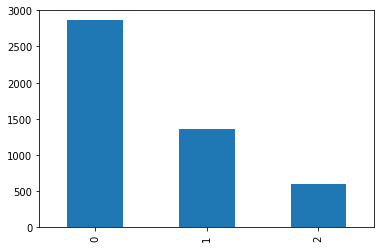

In [ ]:
dataset['labels'].value_counts().plot(kind = 'bar')

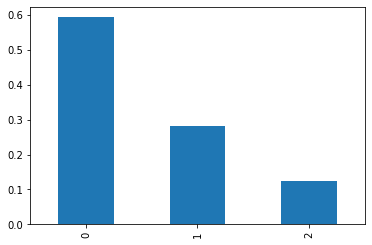

In [ ]:
dataset['labels'].value_counts(normalize = True).plot(kind = 'bar', )

In [ ]:
dataset['labels'].value_counts(normalize = True)

0    0.592708
1    0.282163
2    0.125129
Name: labels, dtype: float64

# 훈련/테스트 데이터 분리

In [ ]:
 #입출력 데이터 분리
X_data = dataset['kor_sentence']
y_data = dataset['labels']

In [ ]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_data)

In [ ]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 3861
테스트 입력 데이터 개수: 966


In [ ]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

0    0.592852
1    0.282051
2    0.125097
Name: labels, dtype: float64

In [ ]:
# 테스트 데이터 라벨별 비율
y_test.value_counts(normalize = True)

0    0.592133
1    0.282609
2    0.125259
Name: labels, dtype: float64

# BERT용 입력 데이터 포맷 변경

In [ ]:
# 데이터 길이 제한
MAX_SEQ_LEN = 64

In [ ]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [ ]:
# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

3861it [00:02, 1920.61it/s]


In [ ]:
# test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

966it [00:00, 1700.40it/s]


# BERT 모델링

In [ ]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [ ]:
bert_outputs

TFSequenceClassifierOutput([('logits',
                             <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'tf_bert_for_sequence_classification_4')>)])

In [ ]:
bert_output = bert_outputs[0]

# 파인튜닝: 감정 분류 모델

## 감정 분류 모델 컴파일

In [ ]:
DROPOUT_RATE = 0.5
NUM_CLASS = 3
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [ ]:
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS, 
                                          warmup_proportion = WARMUP_PROPORTION, 
                                          min_lr = MIN_LR, 
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [ ]:
sentiment_model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

## 조기종료 조건

In [ ]:
MIN_DELTA = 1e-3
PATIENCE = 5

In [ ]:
early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = MIN_DELTA,
    patience = PATIENCE)

## 최고 성능 모델 저장

In [ ]:
#MODEL_BEST_PATH = "./drive/MyDrive/Colab Notebooks/SCFN/model/"
#MODEL_BEST_NAME = "best_model_" + MODEL_NAME + "_" + OPTIMIZER_NAME + ".h5"

In [ ]:
BEST_MODEL_NAME = 'best_model.h5'

model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

## 감정 분류 모델 학습

In [ ]:
EPOCHS = 100
BATCH_SZIE = 32

In [ ]:
sentiment_model.fit(train_x, train_y, 
                    epochs = EPOCHS, 
                    shuffle = True, 
                    batch_size = BATCH_SZIE, 
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 1.0910 - accuracy: 0.5128
Epoch 1: val_loss improved from inf to 1.08513, saving model to best_model.h5
121/121 [==============================] - 88s 389ms/step - loss: 1.0910 - accuracy: 0.5128 - val_loss: 1.0851 - val_accuracy: 0.5911
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.5211
Epoch 2: val_loss improved from 1.08513 to 1.04920, saving model to best_model.h5
121/121 [==============================] - 43s 356ms/step - loss: 1.0697 - accuracy: 0.5211 - val_loss: 1.0492 - val_accuracy: 0.5921
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 1.0333 - accuracy: 0.5403
Epoch 3: val_loss improved from 1.04920 to 0.99976, saving model to best_model.h5
121/121 [==============================] - 43s 356ms/step - loss: 1.0333 - accuracy: 0.5403 - val_loss: 0.9998 - val_accuracy: 0.7091
Epoch 4/100
121/121 [==============================] - ETA: 0s - 

# 감정 분류의 예측값 계산

In [ ]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [ ]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

# 감정 분류 모델의 성능 평가

## Classification Report

In [ ]:
cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv("cl_report.csv")
print(cl_report_df)

              precision  recall  f1-score  support
0                 0.878   0.890     0.884  572.000
1                 0.763   0.780     0.772  273.000
2                 0.822   0.727     0.772  121.000
accuracy          0.839   0.839     0.839    0.839
macro avg         0.821   0.799     0.809  966.000
weighted avg      0.838   0.839     0.838  966.000


## Confusion Matrix

In [ ]:
# 이미지 파일 저장정보
# FIGURE_PATH = "./drive/MyDrive/Colab Notebooks/SCFN/figure/"
# FIGURE_NAME = "cf_matrix_" + MODEL_NAME + "_" + OPTIMIZER_NAME + ".png"

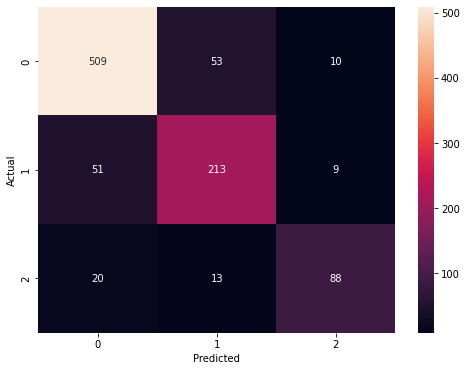

In [ ]:
cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.savefig(FIGURE_PATH + FIGURE_NAME)
plt.show()

## Accracy

In [ ]:
accuracy_score_v = round(accuracy_score(y_test, predicted_label), 3)

## Precision

In [ ]:
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 3)

## Recall

In [ ]:
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 3)

## F1 Score

In [ ]:
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 3)

## ROC AUC Score

In [ ]:
roc_auc_score_v = round(roc_auc_score(y_test, predicted_value, average="weighted", multi_class="ovr"), 3)

## Cohen’s Kappa score

In [ ]:
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 3)

## Matthew’s correlation coefficient

In [ ]:
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 3)

## Log loss

In [ ]:
log_loss_v = round(log_loss(y_test, predicted_value), 3)

## 전체 평가지표

In [ ]:
#METRIC_PATH = "./drive/MyDrive/Colab Notebooks/SCFN/metric/"
#METRIC_NAME = "metric_" + MODEL_NAME + "_" + OPTIMIZER_NAME + ".csv"

In [ ]:
metric_total = pd.DataFrame({
    'PLM': MODEL_NAME,
    'Optimizer': OPTIMIZER_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'ROC_AUC_score': roc_auc_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['score'])

In [ ]:
#metric_total.to_csv(METRIC_PATH + METRIC_NAME)

In [ ]:
print(metric_total)

                  PLM Optimizer  Accuracy  Precision  Recall  F1_score  \
score  klue/bert-base     RAdam     0.839      0.838   0.839     0.838   

       ROC_AUC_score  Cohen_kappa_coef  Matthews_corrcoef  Log_loss  
score          0.924             0.706              0.706       0.5  
